Тема проекта: "Квантильные методы оценки рисков дорогостоящих дефектов в строительных объектах"
Винокуров Т.Р.

Набор данных содержит информацию о строительных работах:
1. Наименование работ - описание вида строительных работ с указанием локации
2. Прямые затраты, руб - целевая переменная, стоимость выполнения работ
3. Затраты труда, чел.ч - трудоемкость работ в человеко-часах

Особенности данных: cильная асимметрия целевой переменной(тяжелый правый хвост), наличие экстремальных значений(от 15 руб. до 325000 руб.)

Цель работы: разработка методологии оценки рисков дорогостоящих дефектов в строительных объектах на основе квантильной регрессии для повышения точности прогнозирования максимальных затрат и оптимизации бюджета.

План работы:

1.
Исследовать распределение стоимости строительных работ и выявить статистические особенности данных;
Проанализировать наличие "тяжелых хвостов" распределения и экстремальных значений;
Определить степень асимметрии данных и влияние выбросов на традиционные метрики оценки;

2.
Разработать и реализовать квантильные регрессионные модели для различных уровней вероятности (5%, 25%, 50%, 75%, 95%);
Сравнить эффективность моделей с логарифмированием и без него для данных со значительной асимметрией;
Подобрать и обосновать метрики оценки качества квантильных моделей;

3.
Построить прогнозные модели для оценки потенциальных максимальных затрат (95%);
Разработать рекомендации по выбору оптимальной модели в зависимости от цели прогнозирования;
Предложить методику расчета резервов бюджета на основе разницы между медианными и верхними квантильными оценками;

4.
Провести сравнительный анализ качества моделей по ключевым метрикам (Pinball Loss, WAPE, Median APE);
Проанализировать практическую значимость полученных результатов для управления рисками в строительстве;


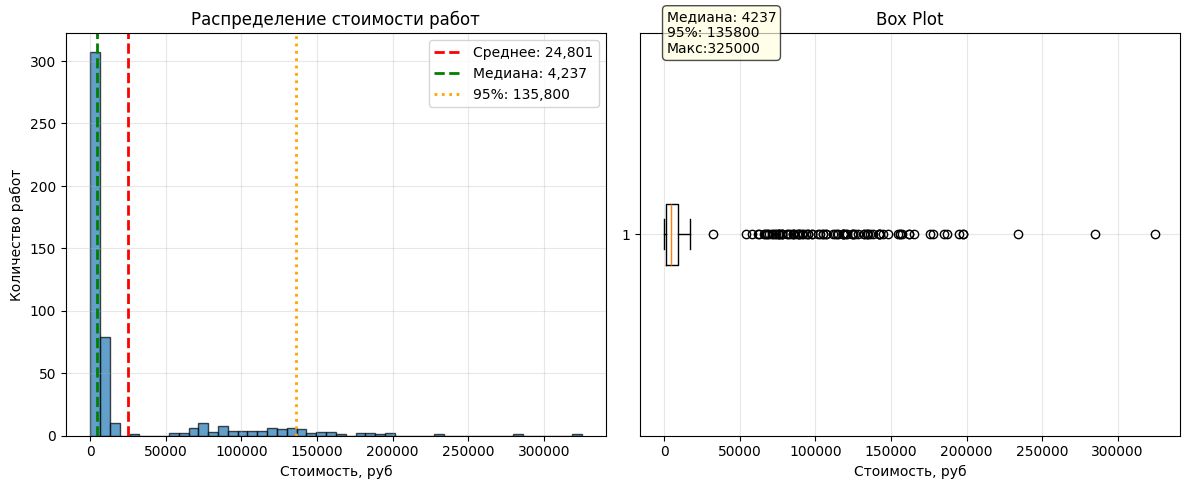

Основные выводы для постановки проблемы:
1. Среднее / Медиана = 5.85 (сильная асимметрия)
2. 95% / Медиана = 32.05 (тяжелый хвост)
3. 99% / Медиана = 46.14 (экстремальные значения)
4. Максимум / 95% = 2.39 (выбросы в хвосте)
5. 15.7% работ дают 80% общей стоимости
6. Коэффициент асимметрии = 2.51 (правая асимметрия)


In [71]:
#Тема проекта: "Квантильные методы оценки рисков дорогостоящих дефектов в строительных объектах" Винокуров Т.Р.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('/content/fer_proc.xlsx')
costs = df['Прямые затраты, руб']

#Основные метрики
mean_cost = costs.mean()
median_cost = costs.median()
p95 = costs.quantile(0.95)
p99 = costs.quantile(0.99)

#Гистограмма с основными метриками
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(costs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_cost, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_cost:,.0f}')
plt.axvline(median_cost, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median_cost:,.0f}')
plt.axvline(p95, color='orange', linestyle=':', linewidth=2, label=f'95%: {p95:,.0f}')
plt.xlabel('Стоимость, руб')
plt.ylabel('Количество работ')
plt.title('Распределение стоимости работ')
plt.legend()
plt.grid(True, alpha=0.3)

#Ящик с усами(boxplot) для визуализации выбросов
plt.subplot(1, 2, 2)
plt.boxplot(costs, vert=False)
plt.xlabel('Стоимость, руб')
plt.title('Box Plot')
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Медиана: {median_cost:.0f}\n95%: {p95:.0f}\nМакс:{costs.max():.0f}',transform=plt.gca().transAxes, fontsize=10,bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
plt.tight_layout()
plt.show()

#Правило Парето - 80/20(оставить?).Массив уже отсортирован по убыванию. Сколько % работ дают 80% стоимости?можно добавить график
cumulative_sum = np.cumsum(costs)
cumulative_percentage = cumulative_sum / costs.sum() * 100
items_percentage = np.arange(1, len(costs) + 1) / len(costs) * 100
idx_80 = np.argmax(cumulative_percentage >= 80)
perc_items_80 = items_percentage[idx_80]

#Вывод(исходные данные имеют сильную асимметрию и выбросы - продолжаем к квантильной регрессии)
print("Основные выводы для постановки проблемы:")
print(f"1. Среднее / Медиана = {mean_cost/median_cost:.2f} (сильная асимметрия)")
print(f"2. 95% / Медиана = {p95/median_cost:.2f} (тяжелый хвост)")
print(f"3. 99% / Медиана = {p99/median_cost:.2f} (экстремальные значения)")
print(f"4. Максимум / 95% = {costs.max()/p95:.2f} (выбросы в хвосте)")
print(f"5. {perc_items_80:.1f}% работ дают 80% общей стоимости")
print(f"6. Коэффициент асимметрии = {costs.skew():.2f} (правая асимметрия)")


In [72]:
#Добавим признаки для построения регрессии - тип локации проведения работы и чел.ч(уже есть в исх.данных).
def get_location_type(work_name):
    #Берем часть после "/", т.к. значения могут повторяться в двух частях
    if '/' in str(work_name):
        loc = str(work_name).split('/')[-1].lower()
    else:
        loc = str(work_name).lower()
    #По ключевым словам определяем локацию строительных работ
    if 'кровл' in loc or 'крыш' in loc or 'стропил' in loc:
        return 'Кровля'
    elif 'фасад' in loc or 'стен' in loc or 'штукатурк' in loc:
        return 'Фасад'
    elif 'пол' in loc or 'паркет' in loc or 'плитк' in loc:
        return 'Полы'
    elif 'окон' in loc or 'двер' in loc:
        return 'Окна/Двери'
    elif 'лестниц' in loc or 'ступен' in loc:
        return 'Лестницы'
    elif 'водосточн' in loc or 'труб' in loc:
        return 'Водостоки'
    else:
        return 'Другое'
df['Тип локации'] = df['Наименование работ'].apply(get_location_type)

#Вывод первых 20(может быть добавить в новый файл?)
print(df[['Наименование работ', 'Тип локации', 'Затраты труда, чел.ч']].head(20))
print(f"\nРаспределение типов локаций:")
print(df['Тип локации'].value_counts())
print(f"\nВсего записей: {len(df)}")
#путь = '/content/fer_proc_location.xlsx'
#df.to_excel(путь, index=False)

                                   Наименование работ Тип локации  \
0   58-14 Смена покрытия из листовой стали / Замен...      Кровля   
1   58-14 Смена покрытия из листовой стали / Восст...      Кровля   
2   57-7 Ремонт покрытий из штучного паркета / Рес...        Полы   
3   58-24 Смена кровли из черепицы / Восстановлени...      Кровля   
4   57-7 Ремонт покрытий из штучного паркета / Рес...        Полы   
5   56-5 Ремонт оконных переплетов / Замена витраж...  Окна/Двери   
6   59-5 Ремонт ступеней / Замена мраморных ступен...    Лестницы   
7   53-21 Ремонт и восстановление герметизации сты...       Фасад   
8   61-4 Ремонт штукатурки потолков по камню / Рес...      Другое   
9   58-8 Смена отдельных листов металлической кров...      Кровля   
10  61-5 Ремонт штукатурки потолков / Реставрация ...      Другое   
11  58-5 Ремонт деревянных элементов конструкций к...      Кровля   
12  59-5 Ремонт ступеней / Восстановление гранитны...        Полы   
13  58-7 Ремонт отдельными местами

In [73]:
#Квантильная регрессия и сравнение моделей
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

#Перевод переменной в количественную
df = pd.get_dummies(df, columns=['Тип локации'])

#Логарифмирование
df['log_затраты'] = np.log1p(df['Прямые затраты, руб'])
df['log_труд'] = np.log1p(df['Затраты труда, чел.ч'])

#Признаки
location_cols = [col for col in df.columns if 'Тип локации_' in col]
X_orig = df[['Затраты труда, чел.ч'] + location_cols]
y_orig = df['Прямые затраты, руб']
X_log = df[['log_труд'] + location_cols]
y_log = df['log_затраты']

#Разделение train/test
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42
)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

#Функции для 3 метрик: WAPE(учитывает разные масштабы данных, в % от общей стоимости), Pinball loss(специально для QReg, по сценариям - 0,05; 0,5; 0,95) и MAPE(устойч. к выбросам, т.к. использует медиану, а не среднее)
#Можно еще добавить RMSE, но она сильно штрафует выбросы
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def pinball_loss(y_true, y_pred, q):
    return np.mean(np.maximum(q * (y_true - y_pred),
                             (q - 1) * (y_true - y_pred)))

def median_ape(y_true, y_pred):
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    ape = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100
    return np.median(ape)


In [74]:
#Обучение модели и обработка данных
def train_quantile_model(X_train, X_test, y_train, y_test, q, use_log=False):
    #Преобразуем в numpy arrays и исправляем типы данных, т.к. была ошибка с ними
    X_train_np = np.array(X_train, dtype=np.float64)
    X_test_np = np.array(X_test, dtype=np.float64)
    y_train_np = np.array(y_train, dtype=np.float64)
    y_test_np = np.array(y_test, dtype=np.float64)

    X_train_np = np.nan_to_num(X_train_np)
    X_test_np = np.nan_to_num(X_test_np)
    y_train_np = np.nan_to_num(y_train_np)
    y_test_np = np.nan_to_num(y_test_np)

    #Добавляем константу
    X_train_const = sm.add_constant(X_train_np)
    X_test_const = sm.add_constant(X_test_np)

    #Обучаем модель
    model = QuantReg(y_train_np, X_train_const).fit(q=q)
    y_pred = model.predict(X_test_const)

    #Если использовали логарифмы, преобразуем обратно(иначе будем сравнивать рубли с логарифмами)
    if use_log:
        y_pred = np.expm1(y_pred)
        y_true = y_test_np
    else:
        y_true = y_test_np

    return y_true, y_pred

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

#Обучаем и оцениваем модели
print("Сравнение моделей")

results_summary = []

for q in quantiles:
    #Модель без логарифмирования
    y_true_orig, y_pred_orig = train_quantile_model(
        X_train_orig, X_test_orig, y_train_orig, y_test_orig, q, use_log=False
    )

    #Модель с логарифмированием
    y_true_log, y_pred_log = train_quantile_model(
        X_train_log, X_test_log, y_train_log, y_test_orig, q, use_log=True  # Используем y_test_orig для сравнения в одной шкале
    )

    #Метрики для обеих моделей
    wape_orig = wape(y_true_orig, y_pred_orig)
    wape_log = wape(y_true_log, y_pred_log)

    pinball_orig = pinball_loss(y_true_orig, y_pred_orig, q)
    pinball_log = pinball_loss(y_true_log, y_pred_log, q)

    med_ape_orig = median_ape(y_true_orig, y_pred_orig)
    med_ape_log = median_ape(y_true_log, y_pred_log)

    #Определяем лучшую модель по Pinball Loss(выбрать другую метрику?)
    better_model = 'ЛОГ' if pinball_log < pinball_orig else 'ОРИГ'

    results_summary.append({
        'Квантиль': q,
        'WAPE_ОРИГ': wape_orig,
        'WAPE_ЛОГ': wape_log,
        'Pinball_ОРИГ': pinball_orig,
        'Pinball_ЛОГ': pinball_log,
        'MedAPE_ОРИГ': med_ape_orig,
        'MedAPE_ЛОГ': med_ape_log,
        'Лучшая Pinball': better_model})

#Выводим результаты
results_df = pd.DataFrame(results_summary)
print("\nРезультаты сравнения моделей:")
print(results_df.round(2).to_string(index=False))

Сравнение моделей

Результаты сравнения моделей:
 Квантиль  WAPE_ОРИГ  WAPE_ЛОГ  Pinball_ОРИГ  Pinball_ЛОГ  MedAPE_ОРИГ  MedAPE_ЛОГ Лучшая Pinball
     0.05      93.84     95.02       1393.26      1409.86        82.17       83.02           ОРИГ
     0.25      91.86     91.80       6846.51      6834.16        64.84       57.01            ЛОГ
     0.50      91.26     91.85      13478.23     13564.80        71.27       69.13           ОРИГ
     0.75     141.03     92.73      18413.00     12833.89        93.86       85.33            ЛОГ
     0.95     267.80    125.22       6996.47      3542.14       160.51      652.85            ЛОГ


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Выводы, визуализация - сравнение метрик, важность логарифмирования длял оценки рисков в случае асимметричного распределения, дать рекомендации

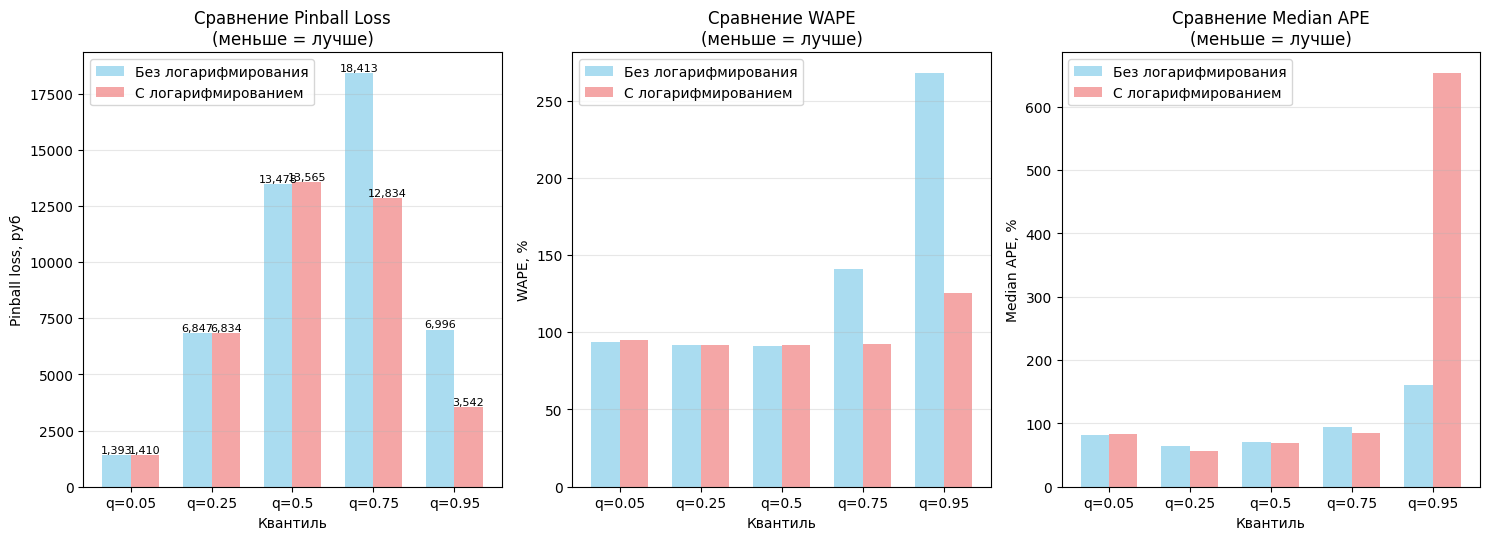

In [75]:
#Визуализация
plt.figure(figsize=(15, 10))

#Сравнение Pinball loss для всех квантилей
plt.subplot(2, 3, 1)
x_pos = np.arange(len(quantiles))
width = 0.35

pinball_orig = results_df['Pinball_ОРИГ'].values
pinball_log = results_df['Pinball_ЛОГ'].values

bars1 = plt.bar(x_pos - width/2, pinball_orig, width, label='Без логарифмирования', alpha=0.7, color='skyblue')
bars2 = plt.bar(x_pos + width/2, pinball_log, width, label='С логарифмированием', alpha=0.7, color='lightcoral')

plt.xlabel('Квантиль')
plt.ylabel('Pinball loss, руб')
plt.title('Сравнение Pinball Loss\n(меньше = лучше)')
plt.xticks(x_pos, [f'q={q}' for q in quantiles])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Подписи значений на столбцах
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=8)

#Сравнение WAPE
plt.subplot(2, 3, 2)
wape_orig = results_df['WAPE_ОРИГ'].values
wape_log = results_df['WAPE_ЛОГ'].values

bars1 = plt.bar(x_pos - width/2, wape_orig, width, label='Без логарифмирования', alpha=0.7, color='skyblue')
bars2 = plt.bar(x_pos + width/2, wape_log, width, label='С логарифмированием', alpha=0.7, color='lightcoral')

plt.xlabel('Квантиль')
plt.ylabel('WAPE, %')
plt.title('Сравнение WAPE\n(меньше = лучше)')
plt.xticks(x_pos, [f'q={q}' for q in quantiles])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

#Сравнение MAPE
plt.subplot(2, 3, 3)
med_ape_orig = results_df['MedAPE_ОРИГ'].values
med_ape_log = results_df['MedAPE_ЛОГ'].values

bars1 = plt.bar(x_pos - width/2, med_ape_orig, width, label='Без логарифмирования', alpha=0.7, color='skyblue')
bars2 = plt.bar(x_pos + width/2, med_ape_log, width, label='С логарифмированием', alpha=0.7, color='lightcoral')

plt.xlabel('Квантиль')
plt.ylabel('Median APE, %')
plt.title('Сравнение Median APE\n(меньше = лучше)')
plt.xticks(x_pos, [f'q={q}' for q in quantiles])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

#Анализ для ключевых квантилей(риск, бюджет, резервы). Сравнение и рекомендации.
